In [169]:
import glob
import logging
import os
import re
import warnings
from typing import List
from typing import Union

import pandas as pd
from matplotlib import pyplot as plt
from pandas import DataFrame
import numpy as np
from pathlib import Path

In [170]:
DEBUGGING: bool = False

if DEBUGGING:
    logging.basicConfig(format='%(asctime)s - %(levelname)s - %(message)s',
                        level=logging.DEBUG)
    warnings.filterwarnings("default")
else:
    logging.disable(logging.CRITICAL)
    warnings.filterwarnings("ignore")

In [171]:
def remove_non_numeric_data(df: pd.DataFrame) -> pd.DataFrame:
    """Removes non-numeric columns from a DataFrame (except for the first column)."""
    cols_to_drop = []
    for col in df.columns[1:]:
        if df[col].dtype not in ['float64', 'int64']:
            cols_to_drop.append(col)
    return df.drop(cols_to_drop, axis=1)


def filter_by_years(df: pd.DataFrame,
                    years_to_analyze: List[int]) -> pd.DataFrame:
    """Filters a DataFrame based on the specified years."""
    time_col = \
        df.filter(regex=r'.*Time.*|.*Obsdate*.|.*time-tag*.').columns[0]
    return df[df[time_col].dt.year.isin(years_to_analyze)]


def rename_time_columns_to_universal_format(df: pd.DataFrame) -> pd.DataFrame:
    """Renames time columns to a universal format (time0, time1, etc.)."""
    time_cols = df.filter(
        regex=r'.*Time.*|.*Obsdate*.|.*time-tag*.').columns
    df.columns = [f'time{i}' if col in time_cols else col for i, col in
                  enumerate(df.columns)]
    return df


def convert_to_universal_time_format(df: pd.DataFrame,
                                     time_period: str = 'M') -> pd.DataFrame:
    """Converts time columns in a DataFrame to a universal format and groups by the time period."""
    time_cols = df.filter(
        regex=r'.*Time.*|.*Obsdate*.|.*time-tag*.').columns
    df[time_cols] = df[time_cols].apply(pd.to_datetime,
                                        errors='coerce').apply(
        lambda s: s.dt.to_period(time_period))
    return df.groupby(time_cols[0]).median().reset_index()


def preprocess_solar_data(solar_data_file: Union[
    os.PathLike, str]) -> pd.DataFrame:
    """Preprocesses solar data by handling missing values and converting time formats."""
    df = pd.read_json(solar_data_file)
    df.dropna(inplace=True)
    df = convert_to_universal_time_format(df)
    return df


def preprocess_satellite_data(satellite_data_file: Union[os.PathLike, str],
                              years_to_analyze: List[int]) -> pd.DataFrame:
    """Preprocesses satellite data by removing non-numeric columns, converting time formats, and filtering by years."""
    df = pd.read_csv(satellite_data_file)
    df = remove_non_numeric_data(df)
    df = convert_to_universal_time_format(df)
    df = filter_by_years(df, years_to_analyze)
    return df


def merge_dataframes_by_time(df1: pd.DataFrame,
                             df2: pd.DataFrame) -> pd.DataFrame:
    """Merges two DataFrames based on their time columns."""
    df1 = rename_time_columns_to_universal_format(df1)
    df2 = rename_time_columns_to_universal_format(df2)
    return pd.merge(df1, df2, how='inner')


class SatelliteAnalyzer:
    def __init__(self, sat_name: str):
        self.sat_name = sat_name
        self.plot_sat_name = sat_name
        self.plot_desc_data_name = ""  # To be set later
        self.years_to_analyze: List[int] = [2023, 2022, 2021, 2020, 2019,
                                            2018, 2017, 2016, 2015,
                                            2014]

    def _plot_scatter_single_or_multiple(self, df: pd.DataFrame, x_col: str,
                                         y_cols: List[str]) -> None:
        """Plots scatter plots for one or multiple y-columns against a single x-column."""
        markers = ['o', 's', '^', 'P', 'D', 'x', '+', 'v', '<', '>', '1', '2',
                   '3', '4']
        markers = np.tile(markers, len(y_cols) // len(markers) + 1)[
                  :len(y_cols)]

        plt.figure(figsize=(10, 8))
        for i, y_col in enumerate(y_cols):
            plt.scatter(df[x_col], df[y_col], label=y_col, marker=markers[i])

        plt.title(
            f'{self.plot_sat_name}: {x_col} aka [{self.plot_desc_data_name}] vs {"multiple Y-columns" if len(y_cols) > 1 else y_cols[0]}')
        plt.xlabel('Количество аварийных перезагрузок')
        plt.ylabel('Индикаторы солнечной активности')
        plt.legend()
        plt.subplots_adjust(bottom=0.2)
        plt.show()

    def _plot(self, df: pd.DataFrame,
              col_list1: List[str],
              col_list2: List[str]) -> None:
        for col1 in col_list1:
            self._plot_scatter_single_or_multiple(df, col1,
                                                  [y for y in col_list2 if
                                                   y != col1])

    def process(self, solar_data_file: Union[os.PathLike, str],
                satellite_data_file: Union[os.PathLike, str]) -> None:
        df_solar = preprocess_solar_data(solar_data_file)
        df_satellite = preprocess_satellite_data(satellite_data_file,
                                                 self.years_to_analyze)

        # Select relevant columns (excluding time-related ones)
        solar_cols = df_solar.columns[~df_solar.columns.str.contains(
            r'.*Time.*|.*Obsdate*.|.*time-tag*.')]
        satellite_cols = df_satellite.columns[
            ~df_satellite.columns.str.contains(
                r'.*Time.*|.*Obsdate*.|.*time-tag*.')]

        # Remove nearly constant satellite columns
        for col in satellite_cols:
            if df_satellite[col].var() <= 1e-13:
                # logging.warning(f"Column '{col}' is nearly constant, skipping.")  
                df_satellite.drop(col, axis=1, inplace=True)
                satellite_cols = satellite_cols.drop(col)

        df_merged = merge_dataframes_by_time(df_solar, df_satellite)
        self._plot(df_merged, satellite_cols,
                   solar_cols)

    def start_analysis(self):
        data_dir: Path = Path("../data")
        solar_data_path: Path = data_dir / "observed_solar_cycle_indices.json"
        satellite_data_files: List[Path] = list(
            (data_dir / self.sat_name).glob("*.csv"))

        for sat_file in satellite_data_files:
            try:
                self.plot_desc_data_name = os.path.basename(sat_file)
                self.plot_desc_data_name = re.sub(r'-\d.*$|\.\w+$', '',
                                                  self.plot_desc_data_name,
                                                  flags=re.IGNORECASE)

                self.process(solar_data_file=solar_data_path,
                             satellite_data_file=os.path.abspath(sat_file))
            except Exception as ex:
                logging.exception(
                    f"Unexpected error processing file=[{sat_file}] : {ex}")
                pass

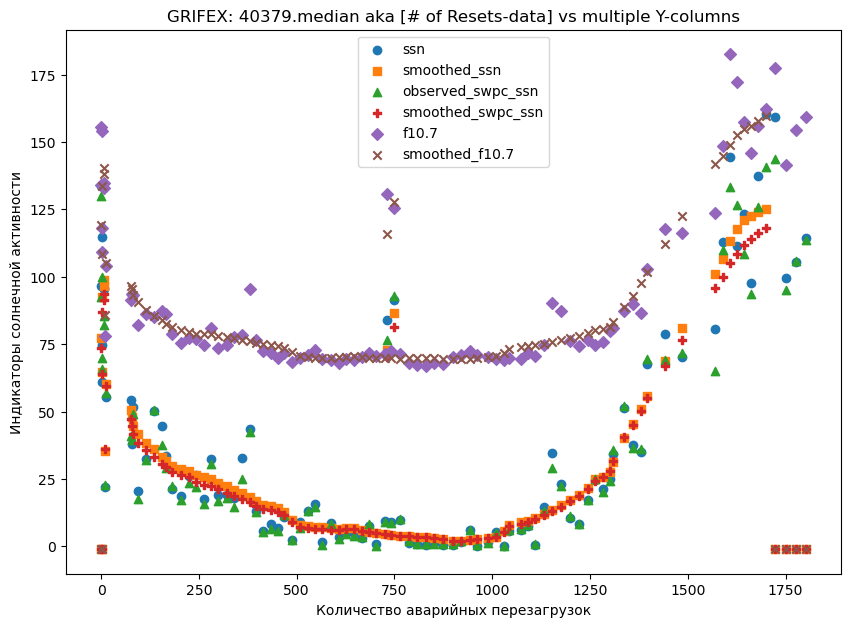

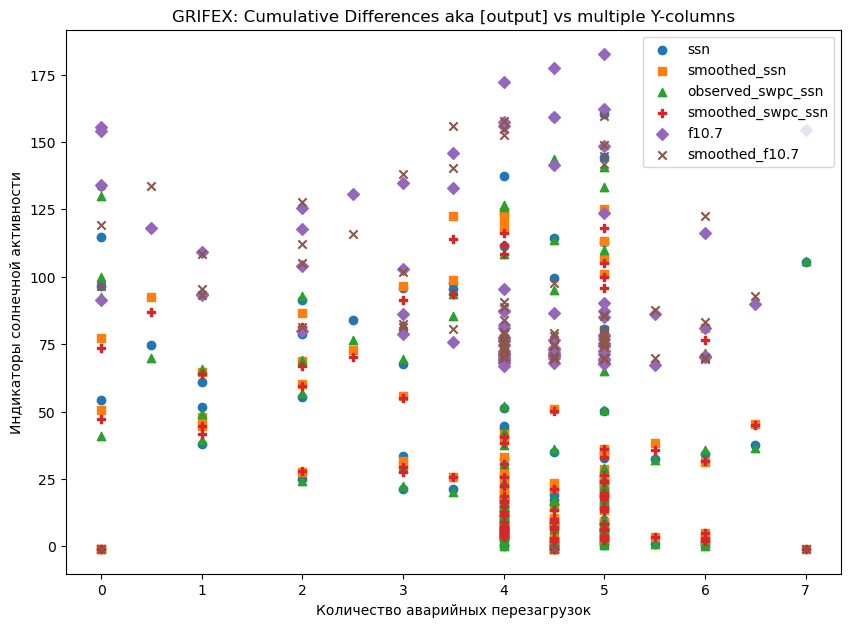

In [172]:
grifex_analyzer = SatelliteAnalyzer(sat_name="GRIFEX")

grifex_analyzer.start_analysis() 